In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression
from xgboost import XGBClassifier
from scipy.stats import boxcox
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
sns.set_theme(style="ticks", palette='muted')

In [8]:
df=pd.read_csv('hazadous_filled.csv',index_col=0)

In [11]:
df.head()

,LOCATION_LATITUDE,LOCATION_LONGITUDE,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE_BBLS,INTENTIONAL_RELEASE_BBLS,RECOVERED_BBLS,FATAL,INJURE,ACCIDENT_IDENTIFIER,SYSTEM_PART_INVOLVED,...,CPM_IN_PLACE_IND,CAUSE,CAUSE_DETAILS,EST_COST_OPER_PAID,EST_COST_GAS_RELEASED,EST_COST_PROP_DAMAGE,EST_COST_EMERGENCY,EST_COST_ENVIRONMENTAL,EST_COST_OTHER,EST_COST_TOTAL
ID,,,,,,,,,,,,,,,,,,,,,
0,45.565061,-122.742638,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,0.90,0.00,0.00,0,0,CONTROLLER,ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,...,NO,OTHER ACCIDENT CAUSE,UNKNOWN,0,103,15000,10000,0,0,25103
1,30.549014,-91.168398,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,0.88,0.00,0.88,0,0,"LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS",ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,...,NO,EQUIPMENT FAILURE,NON-THREADED CONNECTION FAILURE,0,160,1000,0,500,0,1660
2,29.845391,-94.908820,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,1.42,8.77,0.00,0,0,"LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS",ONSHORE PUMP/METER STATION EQUIPMENT AND PIPING,...,NO,EQUIPMENT FAILURE,NON-THREADED CONNECTION FAILURE,0,646,2500,0,0,0,3146
3,29.845391,-94.908820,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,0.53,8.77,0.00,0,0,"LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS",ONSHORE PUMP/METER STATION EQUIPMENT AND PIPING,...,NO,EQUIPMENT FAILURE,NON-THREADED CONNECTION FAILURE,0,594,2500,0,0,0,3094
5,29.988186,-93.987212,CRUDE OIL,13.00,0.00,13.00,0,0,"LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS",ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,...,NO,CORROSION FAILURE,INTERNAL CORROSION,0,1040,50000,95000,75000,0,221040


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4055 entries, 0 to 5137
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LOCATION_LATITUDE            4055 non-null   float64
 1   LOCATION_LONGITUDE           4055 non-null   float64
 2   COMMODITY_RELEASED_TYPE      4055 non-null   object 
 3   UNINTENTIONAL_RELEASE_BBLS   4055 non-null   float64
 4   INTENTIONAL_RELEASE_BBLS     4055 non-null   float64
 5   RECOVERED_BBLS               4055 non-null   float64
 6   FATAL                        4055 non-null   int64  
 7   INJURE                       4055 non-null   int64  
 8   ACCIDENT_IDENTIFIER          4055 non-null   object 
 9   SYSTEM_PART_INVOLVED         4055 non-null   object 
 10  DESIGNATED_LOCATION          4055 non-null   object 
 11  FEDERAL                      4055 non-null   object 
 12  LOCATION_TYPE                4055 non-null   object 
 13  INCIDENT_AREA_TYPE

# Descriptive Analysis

Text(0, 0.5, 'Cause Catetory')

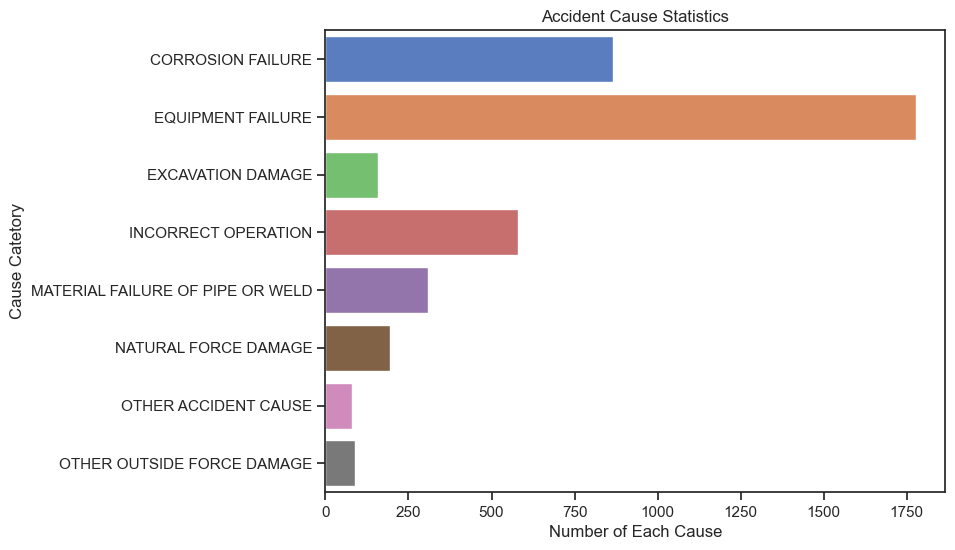

In [28]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='CAUSE',order=sorted(df['CAUSE'].unique()))
plt.title('Accident Cause Statistics')
plt.xlabel('Number of Each Cause')
plt.yticks(fontsize=11)
plt.ylabel('Cause Catetory')
#plt.savefig("Cause Statistics.png", dpi=300)

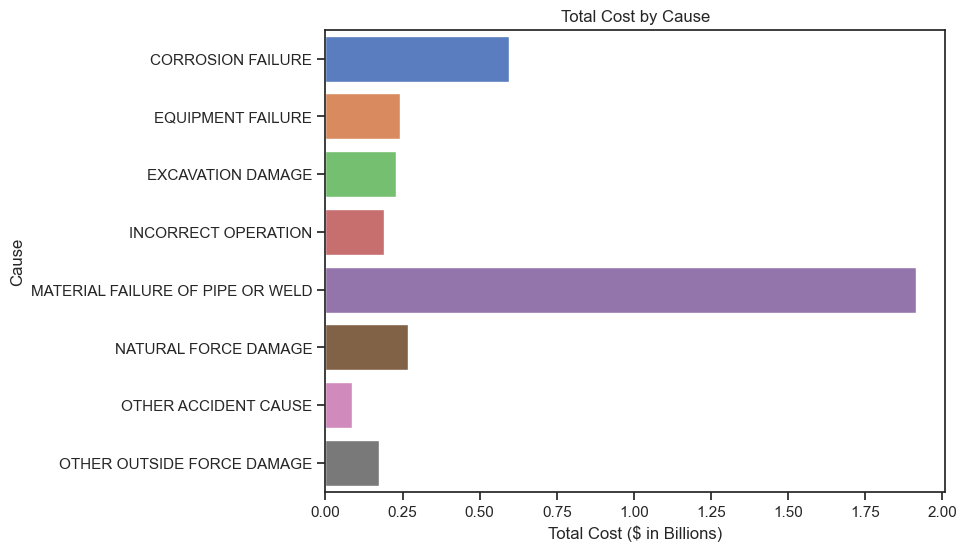

In [30]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df, x='EST_COST_TOTAL', y='CAUSE', estimator=sum, ci=None, order=sorted(df['CAUSE'].unique()))

def format_func(value, tick_number):
    return f'{value / 1e9:.2f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel("Total Cost ($ in Billions)")
plt.yticks(fontsize=11)
plt.ylabel("Cause")
plt.title("Total Cost by Cause")
#plt.savefig("Cost by Cause.png", dpi=500)
plt.show()

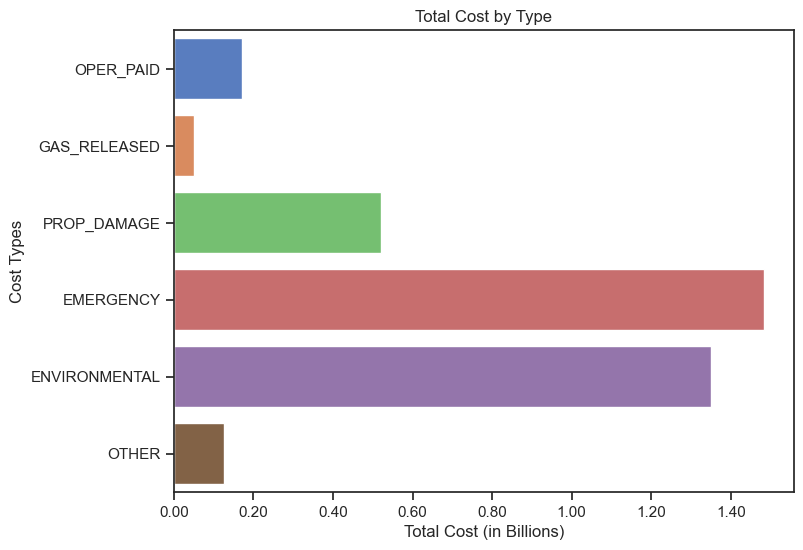

In [27]:
detailed_cost = df[['EST_COST_OPER_PAID','EST_COST_GAS_RELEASED','EST_COST_PROP_DAMAGE','EST_COST_EMERGENCY','EST_COST_ENVIRONMENTAL','EST_COST_OTHER']].sum()
detailed_cost = detailed_cost.rename({'EST_COST_OPER_PAID': 'OPER_PAID',
                                            'EST_COST_GAS_RELEASED': 'GAS_RELEASED',
                                            'EST_COST_PROP_DAMAGE': 'PROP_DAMAGE',
                                            'EST_COST_EMERGENCY': 'EMERGENCY',
                                            'EST_COST_ENVIRONMENTAL': 'ENVIRONMENTAL',
                                            'EST_COST_OTHER': 'OTHER'})
plt.figure(figsize=(8, 6))
# plt.bar(detailed_cost.index, detailed_cost.values)
bx = sns.barplot(y=detailed_cost.index, x=detailed_cost.values)

def format_func(value, tick_number):
    return f'{value / 1e9:.2f}'

bx.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel("Total Cost (in Billions)")
plt.yticks(fontsize = 11)
plt.ylabel("Cost Types")
plt.title("Total Cost by Type")
plt.savefig("Cost by type.png", dpi=500)


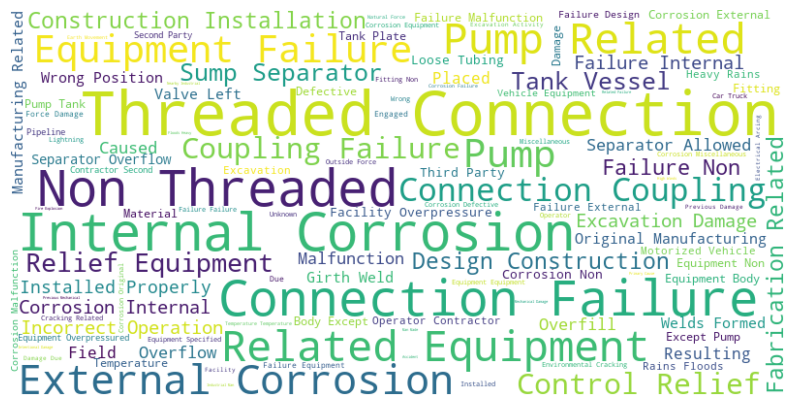

In [23]:
df['CAUSE_DETAILS'] = df['CAUSE_DETAILS'].str.title()
text = df['CAUSE_DETAILS'].str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='white',mode='RGBA').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig("WordCloud of Cause Details.png", dpi=500, bbox_inches='tight', pad_inches=0.1) 
plt.show()

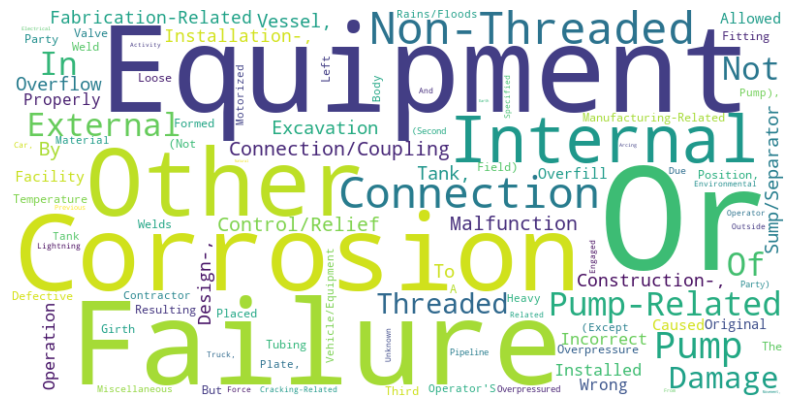

In [24]:
word_freq = Counter(text.split())

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Cause Analysis

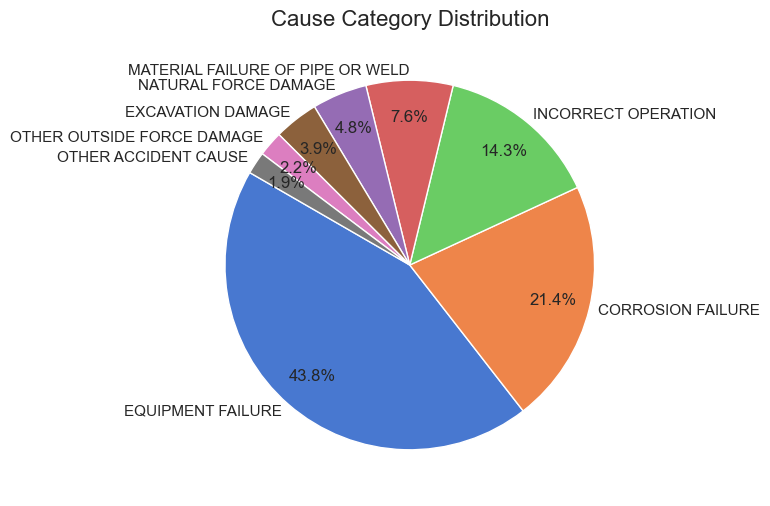

In [25]:
plt.figure(figsize=(8, 6))
cause_counts = df['CAUSE'].value_counts()
plt.pie(cause_counts, labels=cause_counts.index, autopct='%1.1f%%', startangle=150, pctdistance=0.8, labeldistance=1.05)
plt.title('Cause Category Distribution', fontdict={'fontsize':16})
plt.show()

In [31]:
# Drop rows where 'CAUSE' is 'OTHER ACCIDENT CAUSE', 'OTHER OUTSIDE FORCE DAMAGE' and 'NATURAL FORCE DAMAGE'
df = df[(df['CAUSE'] != 'OTHER ACCIDENT CAUSE') & (df['CAUSE'] != 'OTHER OUTSIDE FORCE DAMAGE') & (df['CAUSE'] != 'NATURAL FORCE DAMAGE')]
df.reset_index(drop=True, inplace=True)
df.shape

In [34]:
label_columns = ['CAUSE','CAUSE_DETAILS', 'EST_COST_OPER_PAID', 'EST_COST_GAS_RELEASED', 'EST_COST_PROP_DAMAGE',
                   'EST_COST_EMERGENCY', 'EST_COST_ENVIRONMENTAL', 'EST_COST_OTHER','EST_COST_TOTAL']
features = df.drop(columns=label_columns+['ACCIDENT_IDENTIFIER','DESIGNATED_LOCATION','LOCATION_LATITUDE', 'LOCATION_LONGITUDE'
                                   ,'INSTALLATION_YEAR', 'INJURE', 'FATAL' ,'WILDLIFE_IMPACT_IND', 'SOIL_CONTAMINATION','WATER_CONTAM_IND'])

In [35]:
X = pd.get_dummies(features, drop_first=True)
y = df['CAUSE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
y_train.value_counts()

EQUIPMENT FAILURE                   1419
CORROSION FAILURE                    700
INCORRECT OPERATION                  455
MATERIAL FAILURE OF PIPE OR WELD     250
EXCAVATION DAMAGE                    129
Name: CAUSE, dtype: int64

In [37]:
#Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42, min_samples_leaf=4, max_depth=10, ccp_alpha=0.001)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the model's accuracy and classification report
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report_str)

Accuracy: 0.8024357239512855

Classification Report:
                                   precision    recall  f1-score   support

               CORROSION FAILURE       0.89      0.92      0.91       167
               EQUIPMENT FAILURE       0.79      0.92      0.85       359
               EXCAVATION DAMAGE       1.00      0.62      0.77        29
             INCORRECT OPERATION       0.64      0.37      0.46       126
MATERIAL FAILURE OF PIPE OR WELD       0.77      0.79      0.78        58

                        accuracy                           0.80       739
                       macro avg       0.82      0.72      0.75       739
                    weighted avg       0.79      0.80      0.79       739



In [57]:
# #This block is for creating the tree graph
# from sklearn.tree import export_graphviz
# import subprocess

# with open("tree.dot", 'w') as f:
#     f = export_graphviz(dt_model, feature_names=X.columns ,out_file=f,filled=True)

# command = 'dot -Tpdf tree.dot -o tree.pdf'
# subprocess.run(command, shell=True)

CompletedProcess(args='dot -Tpdf tree.dot -o tree.pdf', returncode=0)

In [38]:
pd.DataFrame({'Feature':dt_model.feature_names_in_,'Importance':dt_model.feature_importances_}).sort_values('Importance',ascending=False)[0:10]

,Feature,Importance
41,RELEASE_TYPE_LEAK-PINHOLE,0.426714
26,ITEM_INVOLVED_PIPE,0.166701
37,"ITEM_INVOLVED_WELD, INCLUDING HEAT-AFFECTED ZONE",0.099666
43,RELEASE_TYPE_MECHANICAL PUNCTURE,0.064966
42,RELEASE_TYPE_LEAK-SEAL OR PACKING,0.060493
3,ACCIDENT_PSIG,0.030307
45,RELEASE_TYPE_OVERFILL OR OVERFLOW,0.021790
44,RELEASE_TYPE_OTHER,0.021536
6,COMMODITY_RELEASED_TYPE_HVL OR OTHER FLAMMABLE...,0.020995
38,MATERIAL_INVOLVED_MATERIAL OTHER THAN CARBON S...,0.020055


In [39]:
#Random Forest model
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42, min_samples_split=5, max_features='sqrt')
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report_str)

Accuracy: 0.8064952638700947

Classification Report:
                                   precision    recall  f1-score   support

               CORROSION FAILURE       0.86      0.90      0.88       167
               EQUIPMENT FAILURE       0.79      0.93      0.86       359
               EXCAVATION DAMAGE       0.95      0.66      0.78        29
             INCORRECT OPERATION       0.70      0.37      0.48       126
MATERIAL FAILURE OF PIPE OR WELD       0.80      0.78      0.79        58

                        accuracy                           0.81       739
                       macro avg       0.82      0.73      0.76       739
                    weighted avg       0.80      0.81      0.79       739



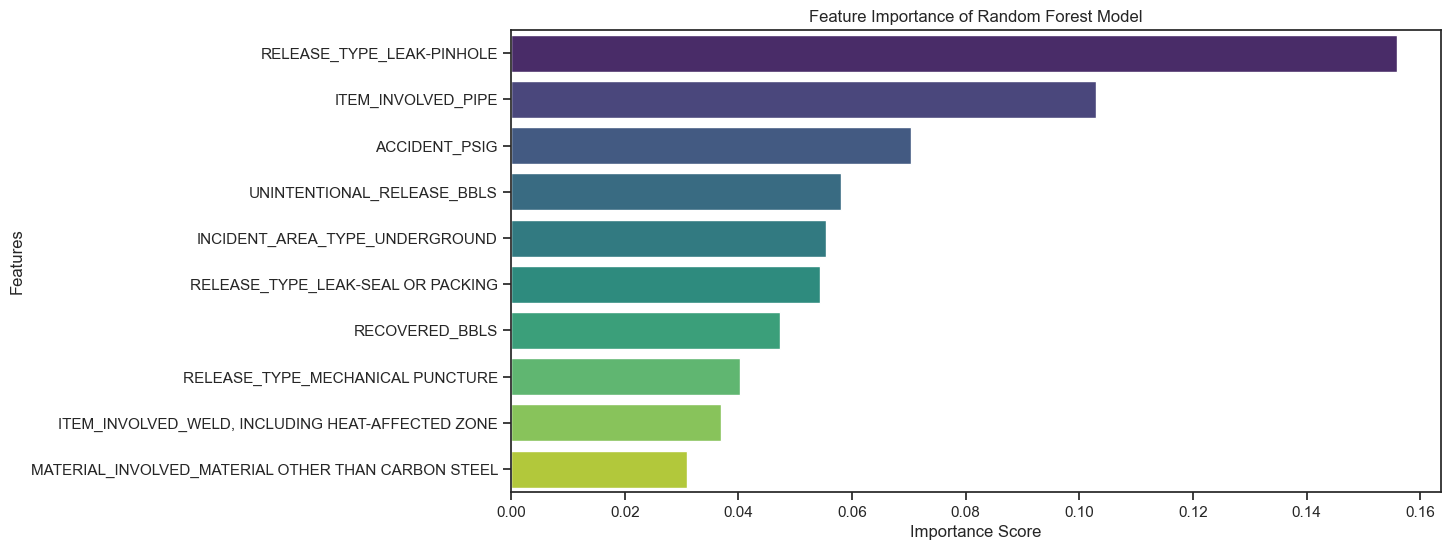

In [40]:
# Get feature importances from the model
feature_importances = rf_model.feature_importances_

feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:10], palette='viridis')
plt.title('Feature Importance of Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [41]:
#Transform the categories to label to fit XGBoost
le = LabelEncoder()
y_train_lab = le.fit_transform(y_train)
y_test_lab=le.transform(y_test)

In [42]:
X_train_renamed=X_train.rename(columns={'PIPELINE_FUNCTION_=< 20% SMYS REGULATED GATHERING':'PIPELINE_FUNCTION_LESS THAN 20% SMYS REGULATED GATHERING',
       'PIPELINE_FUNCTION_> 20% SMYS REGULATED GATHERING':'PIPELINE_FUNCTION_MORE THAN 20% SMYS REGULATED GATHERING',
       'PIPELINE_FUNCTION_> 20% SMYS REGULATED TRANSMISSION':'PIPELINE_FUNCTION_MORE THAN 20% SMYS REGULATED TRANSMISSION'})

X_test_renamed=X_test.rename(columns={'PIPELINE_FUNCTION_=< 20% SMYS REGULATED GATHERING':'PIPELINE_FUNCTION_LESS THAN 20% SMYS REGULATED GATHERING',
       'PIPELINE_FUNCTION_> 20% SMYS REGULATED GATHERING':'PIPELINE_FUNCTION_MORE THAN 20% SMYS REGULATED GATHERING',
       'PIPELINE_FUNCTION_> 20% SMYS REGULATED TRANSMISSION':'PIPELINE_FUNCTION_MORE THAN 20% SMYS REGULATED TRANSMISSION'})

In [44]:
#XGBoost Model
xgb=XGBClassifier(learning_rate=0.01, max_depth=4, n_estimators=500)
xgb.fit(X_train_renamed,y_train_lab)

y_pred_lab = xgb.predict(X_test_renamed)

accuracy = accuracy_score(y_test_lab, y_pred_lab)
classification_report_str = classification_report(le.inverse_transform(y_test_lab), le.inverse_transform(y_pred_lab))

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report_str)

Accuracy: 0.8105548037889039

Classification Report:
                                   precision    recall  f1-score   support

               CORROSION FAILURE       0.86      0.91      0.89       167
               EQUIPMENT FAILURE       0.80      0.93      0.86       359
               EXCAVATION DAMAGE       1.00      0.69      0.82        29
             INCORRECT OPERATION       0.71      0.39      0.50       126
MATERIAL FAILURE OF PIPE OR WELD       0.81      0.76      0.79        58

                        accuracy                           0.81       739
                       macro avg       0.84      0.74      0.77       739
                    weighted avg       0.81      0.81      0.80       739



In [46]:
#Dive into false predictions
prediction=pd.DataFrame({'predict':y_pred,'actual':y_test})
prediction[((prediction['predict']=='INCORRECT OPERATION'))&(prediction['predict']!=prediction['actual'])]
#prediction[((prediction['pred']=='EQUIPMENT FAILURE'))&(prediction['pred']!=prediction['actual'])]

,predict,actual
567,INCORRECT OPERATION,EQUIPMENT FAILURE
149,INCORRECT OPERATION,EQUIPMENT FAILURE
461,INCORRECT OPERATION,EQUIPMENT FAILURE
3094,INCORRECT OPERATION,EQUIPMENT FAILURE
3215,INCORRECT OPERATION,EQUIPMENT FAILURE
2609,INCORRECT OPERATION,EQUIPMENT FAILURE
2266,INCORRECT OPERATION,EQUIPMENT FAILURE
2663,INCORRECT OPERATION,EQUIPMENT FAILURE
1426,INCORRECT OPERATION,EQUIPMENT FAILURE
251,INCORRECT OPERATION,EQUIPMENT FAILURE


In [47]:
prediction=prediction[(prediction['predict'].isin(['INCORRECT OPERATION', 'EQUIPMENT FAILURE'])) & (prediction['actual'].isin(['INCORRECT OPERATION', 'EQUIPMENT FAILURE']))]
pd.crosstab(prediction['actual'],prediction['predict'])

predict,EQUIPMENT FAILURE,INCORRECT OPERATION
actual,,
EQUIPMENT FAILURE,335,20
INCORRECT OPERATION,73,46


In [48]:
df_comb = df.copy()  # Make a copy of the original DataFrame
mapping = {'EQUIPMENT FAILURE': 'EQUIPMENT FAILURE/INCORRECT OPERATION', 'INCORRECT OPERATION': 'EQUIPMENT FAILURE/INCORRECT OPERATION'}
df_comb['CAUSE'] = df_comb['CAUSE'].map(mapping).fillna(df_comb['CAUSE'])

In [49]:
y_comb = df_comb['CAUSE']
X_train, X_test, y_train_comb, y_test_comb = train_test_split(X, y_comb, test_size=0.2, random_state=42)

In [50]:
#Transform the categories to label to fit XGBoost
le = LabelEncoder()
y_train_lab = le.fit_transform(y_train_comb)
y_test_lab=le.transform(y_test_comb)

In [51]:
X_train_renamed=X_train.rename(columns={'PIPELINE_FUNCTION_=< 20% SMYS REGULATED GATHERING':'PIPELINE_FUNCTION_LESS THAN 20% SMYS REGULATED GATHERING',
       'PIPELINE_FUNCTION_> 20% SMYS REGULATED GATHERING':'PIPELINE_FUNCTION_MORE THAN 20% SMYS REGULATED GATHERING',
       'PIPELINE_FUNCTION_> 20% SMYS REGULATED TRANSMISSION':'PIPELINE_FUNCTION_MORE THAN 20% SMYS REGULATED TRANSMISSION'})

X_test_renamed=X_test.rename(columns={'PIPELINE_FUNCTION_=< 20% SMYS REGULATED GATHERING':'PIPELINE_FUNCTION_LESS THAN 20% SMYS REGULATED GATHERING',
       'PIPELINE_FUNCTION_> 20% SMYS REGULATED GATHERING':'PIPELINE_FUNCTION_MORE THAN 20% SMYS REGULATED GATHERING',
       'PIPELINE_FUNCTION_> 20% SMYS REGULATED TRANSMISSION':'PIPELINE_FUNCTION_MORE THAN 20% SMYS REGULATED TRANSMISSION'})

In [52]:
xgb=XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=500)
xgb.fit(X_train_renamed,y_train_lab)

y_pred_lab = xgb.predict(X_test_renamed)

accuracy = accuracy_score(y_test_lab, y_pred_lab)
classification_report_str = classification_report(le.inverse_transform(y_test_lab), le.inverse_transform(y_pred_lab))

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report_str)

Accuracy: 0.9377537212449256

Classification Report:
                                        precision    recall  f1-score   support

                    CORROSION FAILURE       0.87      0.91      0.89       167
EQUIPMENT FAILURE/INCORRECT OPERATION       0.97      0.98      0.98       485
                    EXCAVATION DAMAGE       1.00      0.66      0.79        29
     MATERIAL FAILURE OF PIPE OR WELD       0.84      0.79      0.81        58

                             accuracy                           0.94       739
                            macro avg       0.92      0.83      0.87       739
                         weighted avg       0.94      0.94      0.94       739



### Specific on EQUIPMENT FAILURE/INCORRECT OPERATION

In [53]:
X_train_sub = X_train[y_train_lab==1]
y_train_sub = y_train[y_train_lab==1]
X_test_sub = X_test[y_pred_lab==1]
y_test_sub = y_test[y_pred_lab==1]
(len(y_train_sub),len(y_test_sub))

(1874, 491)

In [54]:
y_test_sub.value_counts()

EQUIPMENT FAILURE      355
INCORRECT OPERATION    121
CORROSION FAILURE       12
EXCAVATION DAMAGE        3
Name: CAUSE, dtype: int64

### Compare different 2nd-step models

In [61]:
#Logisric Regression
model=LogisticRegression(max_iter=10000, penalty='l2', C=1)

model.fit(X_train_sub, y_train_sub)
y_pred_sub = model.predict(X_test_sub)
accuracy = accuracy_score(y_test_sub, y_pred_sub)
report = classification_report(y_test_sub, y_pred_sub)
print(f"Accuracy: {accuracy}")
print("\nClassification Report of Logistic Regression:\n")
print(report)

Accuracy: 0.7841140529531568

Classification Report of Logistic Regression:

                     precision    recall  f1-score   support

  CORROSION FAILURE       0.00      0.00      0.00        12
  EQUIPMENT FAILURE       0.80      0.93      0.86       355
  EXCAVATION DAMAGE       0.00      0.00      0.00         3
INCORRECT OPERATION       0.68      0.46      0.55       121

           accuracy                           0.78       491
          macro avg       0.37      0.35      0.35       491
       weighted avg       0.75      0.78      0.76       491



In [62]:
model = MLPClassifier(hidden_layer_sizes=(256, 128, 64,32), batch_size=32, early_stopping=True, activation='relu', solver='adam', max_iter=1000)

model.fit(X_train_sub, y_train_sub)
y_pred_sub = model.predict(X_test_sub)
accuracy = accuracy_score(y_test_sub, y_pred_sub)
report = classification_report(y_test_sub, y_pred_sub)
print(f"Accuracy: {accuracy}")
print("\nClassification Report of MLP:\n")
print(report)

Accuracy: 0.7352342158859471

Classification Report of MLP:

                     precision    recall  f1-score   support

  CORROSION FAILURE       0.00      0.00      0.00        12
  EQUIPMENT FAILURE       0.74      0.99      0.84       355
  EXCAVATION DAMAGE       0.00      0.00      0.00         3
INCORRECT OPERATION       0.69      0.09      0.16       121

           accuracy                           0.74       491
          macro avg       0.36      0.27      0.25       491
       weighted avg       0.70      0.74      0.65       491



In [64]:
scaler = StandardScaler()
X_train_sub = scaler.fit_transform(X_train_sub)
pca=PCA(n_components=0.9)
pca.fit(X_train_sub)
X_train_sub=pca.transform(X_train_sub)

model = SVC(kernel='rbf')
model.fit(X_train_sub,y_train_sub)

X_test_sub=scaler.transform(X_test_sub)
X_test_sub=pca.transform(X_test_sub)
y_pred_sub = model.predict(X_test_sub)
accuracy = accuracy_score(y_test_sub, y_pred_sub)
report = classification_report(y_test_sub, y_pred_sub)

print(f"Accuracy: {accuracy}")
print("\nClassification Report of SVM:\n")
print(report)

Accuracy: 0.769857433808554

Classification Report of SVM:

                     precision    recall  f1-score   support

  CORROSION FAILURE       0.00      0.00      0.00        12
  EQUIPMENT FAILURE       0.79      0.93      0.85       355
  EXCAVATION DAMAGE       0.00      0.00      0.00         3
INCORRECT OPERATION       0.65      0.40      0.50       121

           accuracy                           0.77       491
          macro avg       0.36      0.33      0.34       491
       weighted avg       0.73      0.77      0.74       491



##### Logistic regression performs the best

### Final Mixed Model

In [66]:
y_pred=le.inverse_transform(y_pred_lab)
y_pred[y_pred=="EQUIPMENT FAILURE/INCORRECT OPERATION"]=y_pred_sub

In [67]:
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the model's accuracy and classification report
print("Accuracy:", accuracy)
print("\nClassification Report of the Mixed Model:\n", classification_report_str)

Accuracy: 0.8051420838971584

Classification Report of the Mixed Model:
                                   precision    recall  f1-score   support

               CORROSION FAILURE       0.87      0.91      0.89       167
               EQUIPMENT FAILURE       0.79      0.92      0.85       359
               EXCAVATION DAMAGE       1.00      0.66      0.79        29
             INCORRECT OPERATION       0.65      0.39      0.49       126
MATERIAL FAILURE OF PIPE OR WELD       0.84      0.79      0.81        58

                        accuracy                           0.81       739
                       macro avg       0.83      0.73      0.77       739
                    weighted avg       0.80      0.81      0.79       739



# Cost Estimation

### Overall Analytics

In [69]:
data = pd.read_csv("hazadous_filled.csv")

# Drop variables
columns_to_delete = ["ID", "INSTALLATION_YEAR", "EST_COST_OPER_PAID", "EST_COST_GAS_RELEASED", 
                     "EST_COST_PROP_DAMAGE", "EST_COST_EMERGENCY", "EST_COST_ENVIRONMENTAL", "EST_COST_OTHER"]
data.drop(columns=columns_to_delete, inplace=True, errors='ignore')

# Convert numerical variables
numerical_vars = ["LOCATION_LATITUDE", "LOCATION_LONGITUDE", "UNINTENTIONAL_RELEASE_BBLS", 
                  "INTENTIONAL_RELEASE_BBLS", "RECOVERED_BBLS", "ACCIDENT_PSIG", "EST_COST_TOTAL"]
for col in numerical_vars:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Convert categorical variables
categorical_vars = ["COMMODITY_RELEASED_TYPE", "FATAL", "INJURE", "ACCIDENT_IDENTIFIER", 
                    "SYSTEM_PART_INVOLVED", "DESIGNATED_LOCATION", "FEDERAL", 
                    "LOCATION_TYPE", "INCIDENT_AREA_TYPE", "CROSSING", "PIPE_FACILITY_TYPE", 
                    "ITEM_INVOLVED", "MATERIAL_INVOLVED", "RELEASE_TYPE", "WILDLIFE_IMPACT_IND", 
                    "SOIL_CONTAMINATION", "WATER_CONTAM_IND", "COULD_BE_HCA", "COMMODITY_REACHED_HCA", 
                    "ACCIDENT_PRESSURE", "INTERNAL_INSPECTION_IND", "OPERATION_COMPLICATIONS_IND", 
                    "PIPELINE_FUNCTION", "SCADA_IN_PLACE_IND", "CPM_IN_PLACE_IND", "CAUSE", "CAUSE_DETAILS"]
for col in categorical_vars:
    data[col] = data[col].astype('category')

In [71]:
# Check which numerical columns have values less than or equal to 0
columns_to_adjust = []
for col in numerical_vars:
    if data[col].min() <= 0:
        columns_to_adjust.append(col)

# Adjust columns with values less than or equal to 0
for col in columns_to_adjust:
    data[col] = data[col] + abs(data[col].min()) + 1

# Apply Box-Cox transformation to all numerical variables
transformed_data = data.copy()
for col in numerical_vars:
    transformed_data[col], _ = boxcox(data[col])

transformed_data[numerical_vars].head()

,LOCATION_LATITUDE,LOCATION_LONGITUDE,UNINTENTIONAL_RELEASE_BBLS,INTENTIONAL_RELEASE_BBLS,RECOVERED_BBLS,ACCIDENT_PSIG,EST_COST_TOTAL
0,0.703193,361.219646,0.582958,0.000000,0.000000,8.474989,12.321212
1,0.700781,1116.686741,0.574243,0.000000,0.555011,3.963221,8.547408
2,0.700594,1008.187130,0.774720,0.283943,0.000000,13.785431,9.401226
3,0.700594,1008.187130,0.398854,0.283943,0.000000,13.859280,9.378703
4,0.700633,1034.461666,1.812977,0.000000,1.600133,3.440113,15.633692


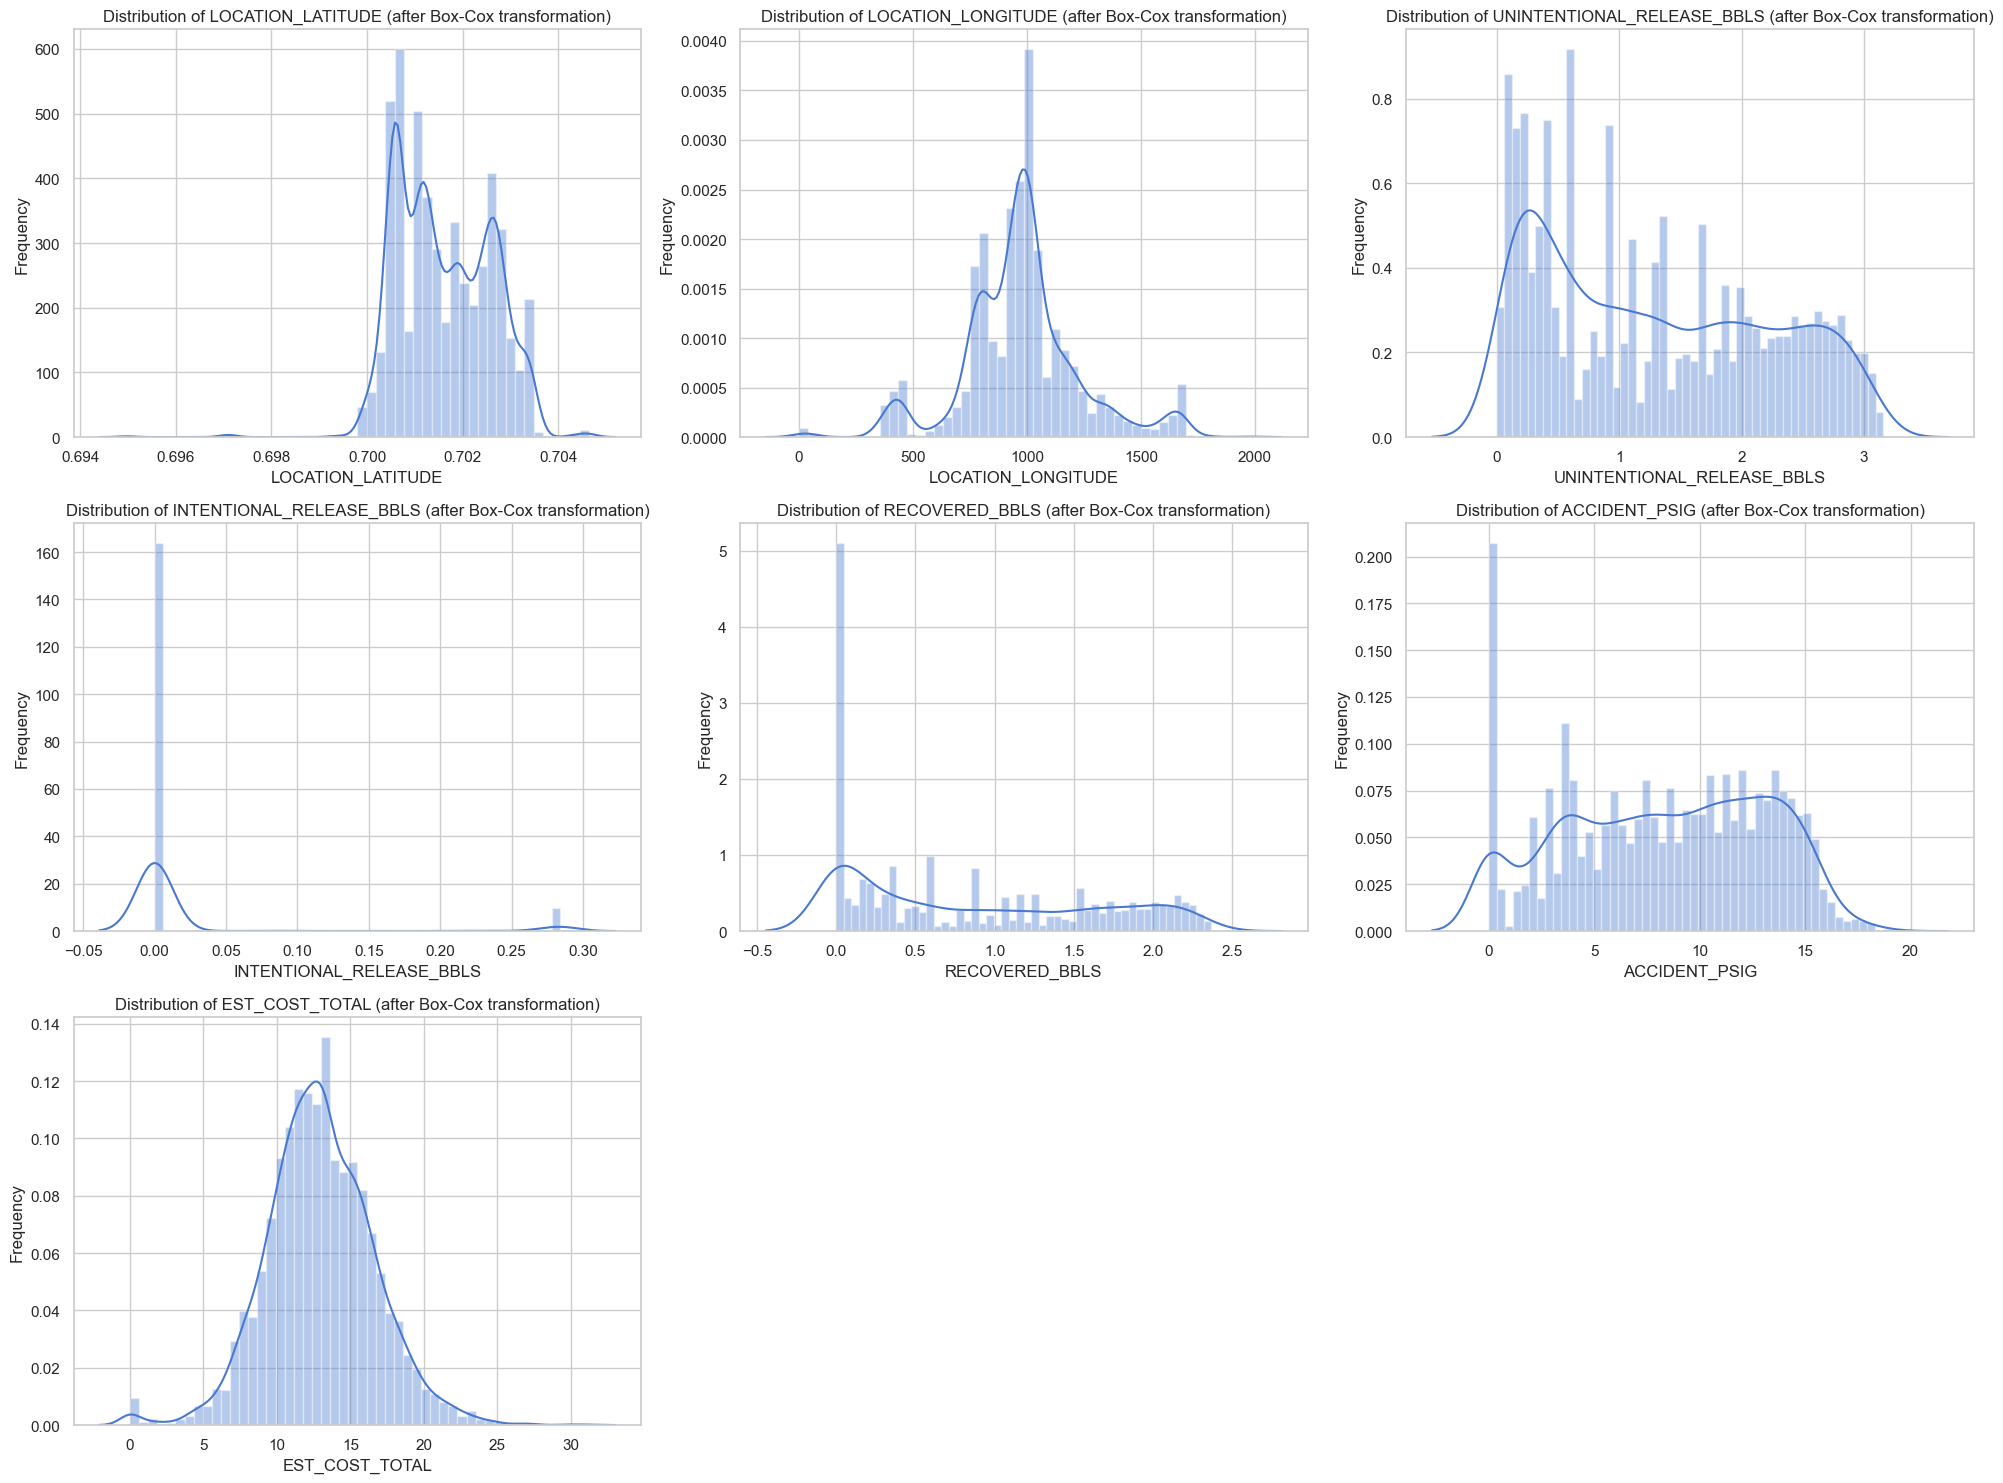

In [72]:
# Plot the distribution of each transformed numerical variable
plt.figure(figsize=(20, 15))

for index, col in enumerate(numerical_vars, 1):
    plt.subplot(3, 3, index)
    sns.distplot(transformed_data[col], bins=50, kde=True)
    plt.title(f'Distribution of {col} (after Box-Cox transformation)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [107]:
# Combine transformed numerical variables with categorical variables
final_data = pd.concat([transformed_data[numerical_vars], data[categorical_vars]], axis=1)

# Identify columns with mixed data types
mixed_type_columns = []
for col in categorical_vars:
    unique_types = {type(item) for item in final_data[col]}
    if len(unique_types) > 1:
        mixed_type_columns.append(col)

# Convert mixed type columns to string
for col in mixed_type_columns:
    final_data[col] = final_data[col].astype(str)

# Apply Label Encoding to categorical variables
label_encoders = {}
for col in categorical_vars:
    le = LabelEncoder()
    final_data[col] = le.fit_transform(final_data[col])
    label_encoders[col] = le

# Display the first few rows of the encoded data
final_data.head()

# Extract the label encoding mappings for each categorical variable
label_mappings = {}
for col, le in label_encoders.items():
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Convert the mappings to a DataFrame for better visualization and export
label_mappings_df = pd.DataFrame.from_dict(label_mappings, orient='index').T

In [110]:
# Load the final_processed_data_without_cause dataset
final_data_without_cause = final_data.drop(columns='CAUSE')

# Apply Variance Threshold
selector = VarianceThreshold()
selected_data = selector.fit_transform(final_data_without_cause)

# Get the columns that were retained
selected_columns = final_data_without_cause.columns[selector.get_support()]

# Convert the selected data back to DataFrame
selected_data_df = pd.DataFrame(selected_data, columns=selected_columns)

# Display the first few rows of the selected data
selected_data_df.head()

,LOCATION_LATITUDE,LOCATION_LONGITUDE,UNINTENTIONAL_RELEASE_BBLS,INTENTIONAL_RELEASE_BBLS,RECOVERED_BBLS,ACCIDENT_PSIG,EST_COST_TOTAL,COMMODITY_RELEASED_TYPE,FATAL,INJURE,...,WATER_CONTAM_IND,COULD_BE_HCA,COMMODITY_REACHED_HCA,ACCIDENT_PRESSURE,INTERNAL_INSPECTION_IND,OPERATION_COMPLICATIONS_IND,PIPELINE_FUNCTION,SCADA_IN_PLACE_IND,CPM_IN_PLACE_IND,CAUSE_DETAILS
0,0.703193,361.219646,0.582958,0.000000,0.000000,8.474989,12.321212,4.0,0.0,0.0,...,0.0,1.0,1.0,2.0,1.0,1.0,3.0,0.0,0.0,36.0
1,0.700781,1116.686741,0.574243,0.000000,0.555011,3.963221,8.547408,4.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,22.0
2,0.700594,1008.187130,0.774720,0.283943,0.000000,13.785431,9.401226,3.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,3.0,1.0,0.0,22.0
3,0.700594,1008.187130,0.398854,0.283943,0.000000,13.859280,9.378703,3.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,3.0,1.0,0.0,22.0
4,0.700633,1034.461666,1.812977,0.000000,1.600133,3.440113,15.633692,2.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,17.0


In [111]:
# Extract the target variable
Y = selected_data_df['EST_COST_TOTAL']
X = selected_data_df.drop(columns=['EST_COST_TOTAL'])
# Compute mutual information between each feature and the target
mutual_info_scores = mutual_info_regression(X, Y, random_state=42)
# Compute mutual information and sort columns by their scores
sorted_columns = X.columns[np.argsort(mutual_info_scores)[::-1]]

# Display the features sorted by their mutual information scores
sorted_features_mi = pd.DataFrame({
    'Feature': sorted_columns,
    'Mutual Information': np.sort(mutual_info_scores)[::-1]
})

sorted_features_mi

,Feature,Mutual Information
0,UNINTENTIONAL_RELEASE_BBLS,0.244509
1,RECOVERED_BBLS,0.228967
2,CAUSE_DETAILS,0.168589
3,RELEASE_TYPE,0.153640
4,ITEM_INVOLVED,0.149411
5,INCIDENT_AREA_TYPE,0.146086
6,LOCATION_TYPE,0.106863
7,SYSTEM_PART_INVOLVED,0.083053
8,OPERATION_COMPLICATIONS_IND,0.070257
9,LOCATION_LONGITUDE,0.063759


In [88]:
# Select columns with positive mutual information scores
selected_features = sorted_features_mi[sorted_features_mi['Mutual Information'] > 0]['Feature'].tolist()

# Filter the data to retain only the selected features
filtered_data = selected_data_df[selected_features]

# Display the first few rows of the filtered data
filtered_data.head()

,UNINTENTIONAL_RELEASE_BBLS,RECOVERED_BBLS,CAUSE_DETAILS,RELEASE_TYPE,ITEM_INVOLVED,INCIDENT_AREA_TYPE,LOCATION_TYPE,SYSTEM_PART_INVOLVED,OPERATION_COMPLICATIONS_IND,LOCATION_LONGITUDE,...,MATERIAL_INVOLVED,INTENTIONAL_RELEASE_BBLS,PIPE_FACILITY_TYPE,DESIGNATED_LOCATION,PIPELINE_FUNCTION,CROSSING,COULD_BE_HCA,SCADA_IN_PLACE_IND,FEDERAL,COMMODITY_REACHED_HCA
0,0.582958,0.000000,36.0,4.0,2.0,0.0,2.0,4.0,1.0,361.219646,...,0.0,0.000000,0.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0
1,0.574243,0.555011,22.0,4.0,17.0,3.0,2.0,4.0,1.0,1116.686741,...,0.0,0.000000,0.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0
2,0.774720,0.000000,22.0,4.0,2.0,0.0,2.0,3.0,1.0,1008.187130,...,1.0,0.283943,1.0,2.0,3.0,0.0,1.0,1.0,0.0,1.0
3,0.398854,0.000000,22.0,4.0,2.0,0.0,2.0,3.0,1.0,1008.187130,...,1.0,0.283943,1.0,2.0,3.0,0.0,1.0,1.0,0.0,1.0
4,1.812977,1.600133,17.0,3.0,9.0,2.0,0.0,4.0,1.0,1034.461666,...,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [89]:
# Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(filtered_data, Y)

# Get feature importances from the model
feature_importances = rf.feature_importances_

# Sort the features based on their importances
sorted_features_rf = pd.DataFrame({
    'Feature': filtered_data.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

sorted_features_rf

,Feature,Importance
0,UNINTENTIONAL_RELEASE_BBLS,0.314896
5,INCIDENT_AREA_TYPE,0.123054
1,RECOVERED_BBLS,0.091892
9,LOCATION_LONGITUDE,0.077925
15,ACCIDENT_PSIG,0.062075
14,LOCATION_LATITUDE,0.058658
3,RELEASE_TYPE,0.039680
11,WATER_CONTAM_IND,0.037631
2,CAUSE_DETAILS,0.036054
4,ITEM_INVOLVED,0.023827


In [90]:
# Select features with importance greater than 0.001
selected_features_rf = sorted_features_rf[sorted_features_rf['Importance'] > 0.001]['Feature'].tolist()

# Filter the data to retain only the selected features
filtered_data_rf = filtered_data[selected_features_rf]

# Display the first few rows of the filtered data
filtered_data_rf.head()

,UNINTENTIONAL_RELEASE_BBLS,INCIDENT_AREA_TYPE,RECOVERED_BBLS,LOCATION_LONGITUDE,ACCIDENT_PSIG,LOCATION_LATITUDE,RELEASE_TYPE,WATER_CONTAM_IND,CAUSE_DETAILS,ITEM_INVOLVED,...,OPERATION_COMPLICATIONS_IND,COMMODITY_REACHED_HCA,MATERIAL_INVOLVED,SCADA_IN_PLACE_IND,COULD_BE_HCA,PIPE_FACILITY_TYPE,PIPELINE_FUNCTION,INTERNAL_INSPECTION_IND,CROSSING,WILDLIFE_IMPACT_IND
0,0.582958,0.0,0.000000,361.219646,8.474989,0.703193,4.0,0.0,36.0,2.0,...,1.0,1.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0
1,0.574243,3.0,0.555011,1116.686741,3.963221,0.700781,4.0,0.0,22.0,17.0,...,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0,0.0
2,0.774720,0.0,0.000000,1008.187130,13.785431,0.700594,4.0,0.0,22.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0
3,0.398854,0.0,0.000000,1008.187130,13.859280,0.700594,4.0,0.0,22.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0
4,1.812977,2.0,1.600133,1034.461666,3.440113,0.700633,3.0,0.0,17.0,9.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [91]:
# Combine the selected features with the target variable (Y)
final_dataset_rf = pd.concat([filtered_data_rf, Y], axis=1)

# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = train_test_split(final_dataset_rf, test_size=0.2, random_state=42)


In [92]:
# Extract features and target from training and testing data
X_train = train_data.drop(columns=['EST_COST_TOTAL'])
y_train = train_data['EST_COST_TOTAL']
X_test = test_data.drop(columns=['EST_COST_TOTAL'])
y_test = test_data['EST_COST_TOTAL']

# Train a Random Forest Regressor on the training data
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

The rmse for our model is 2.306837327182615
The R-Square for our model is 0.6037137652708373

The mae for our model is 1.7202859641386776
The mse for our model is 5.321498454083031
The mape for our model is inf
The smape for our model is 0.15084088147485872


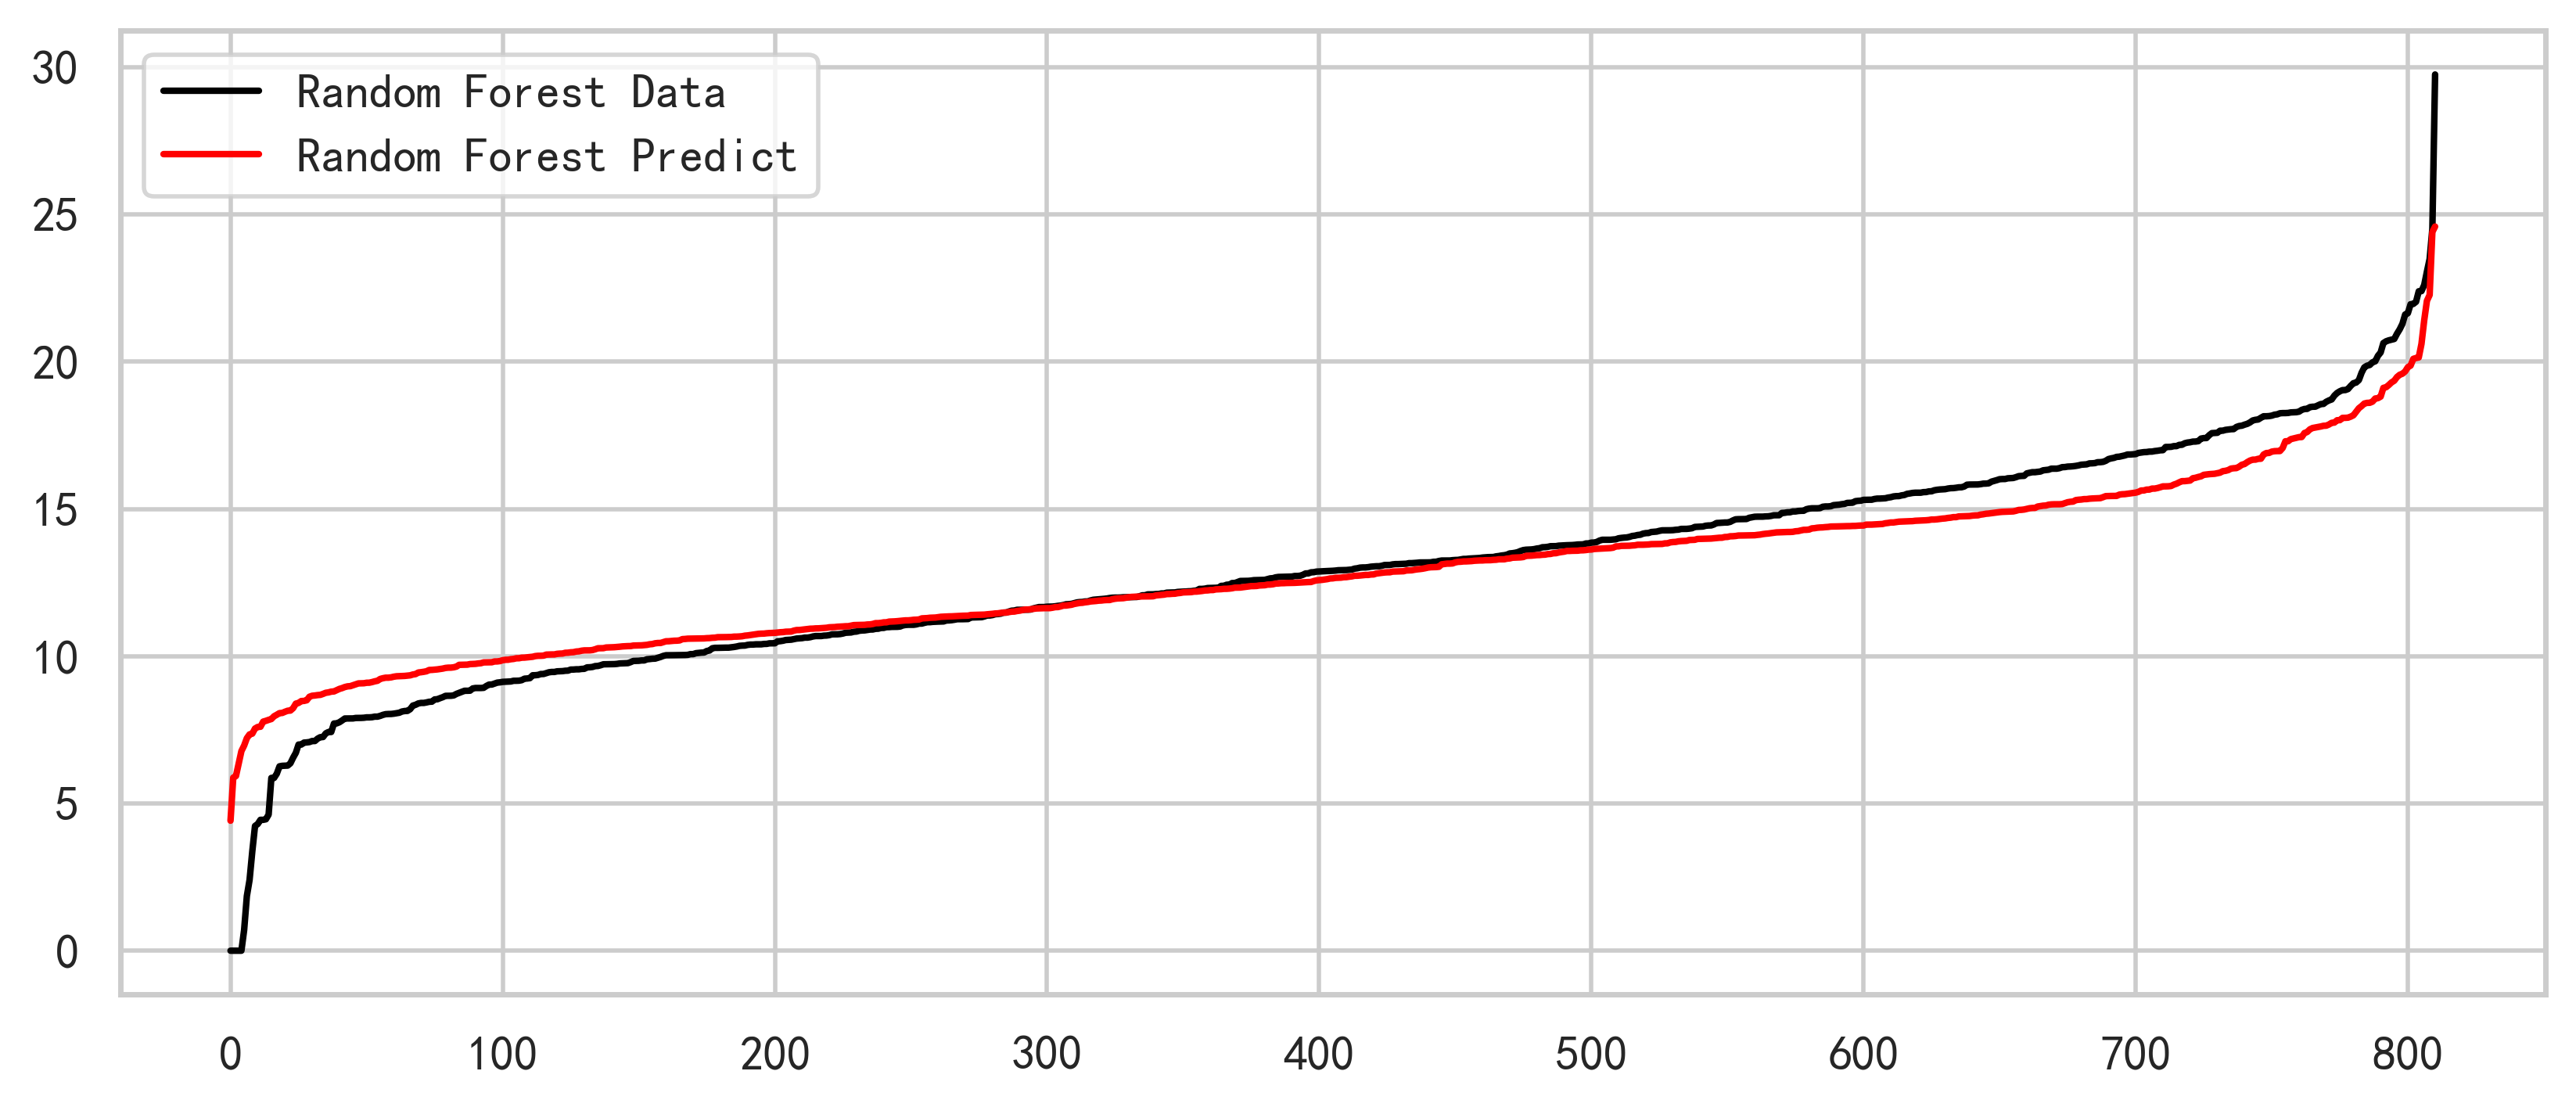

In [98]:
# Define the mape and smape functions
def mape(y_true,y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def smape(y_true,y_pred):
    return 2.0 * np.mean(np.abs(y_pred-y_true)/(np.abs(y_pred)+np.abs(y_true)))

# Define the model_evaluate function
def model_evaluate(y_true,y_pred,tp):
    # RMSE Root mean square error
    print("The rmse for our model is {}".format(np.sqrt(mean_squared_error(y_true,y_pred))))
    # R Squared
    print("The R-Square for our model is {}".format(r2_score(y_true,y_pred)))
    # MAE Mean absolute error
    print("\nThe mae for our model is {}".format(mean_absolute_error(y_true,y_pred)))
    # MSE Mean square error
    print("The mse for our model is {}".format(mean_squared_error(y_true,y_pred)))
    # Mape Mean absolute percentage error
    print("The mape for our model is {}".format(mape(y_true,y_pred)))
    # Smape Symmetric Mean Absolute Percentage Error
    print("The smape for our model is {}".format(smape(y_true,y_pred)))
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.figure(figsize=(10,4),dpi=400)
    plt.plot(range(len(y_true)),sorted(y_true),c="black",label= f"{tp} Data")
    plt.plot(range(len(y_pred)),sorted(y_pred),c="red",label = f"{tp} Predict")
    plt.legend()
    plt.show()

# Now evaluate the Random Forest model using the defined function
model_evaluate(y_test, y_pred, "Random Forest")


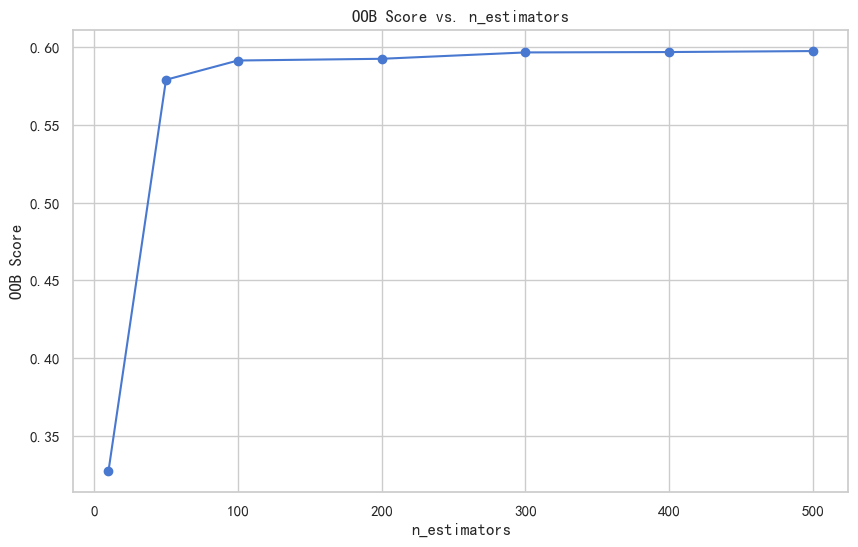

500

In [99]:
# Define a range of values for n_estimators
n_estimators_range = [10, 50, 100, 200, 300, 400, 500]

# Store the OOB scores for each value of n_estimators
oob_scores = []

# Train a Random Forest for each value of n_estimators and record the OOB score
for n in n_estimators_range:
    rf_oob = RandomForestRegressor(n_estimators=n, oob_score=True, random_state=42)
    rf_oob.fit(X_train, y_train)
    oob_scores.append(rf_oob.oob_score_)

# Plot the OOB scores for each value of n_estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, oob_scores, marker='o')
plt.title('OOB Score vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('OOB Score')
plt.grid(True)
plt.show()

# Return the best n_estimators based on OOB score
best_n_estimators = n_estimators_range[np.argmax(oob_scores)]
best_n_estimators

### Detailed Analytics

In [141]:
#Re-import data and do the data filtering same as overall analytics

df = pd.read_csv("hazadous_filled.csv")

columns_to_delete = ["ID", "INSTALLATION_YEAR", "EST_COST_OPER_PAID", "EST_COST_GAS_RELEASED",
                     "EST_COST_PROP_DAMAGE", "EST_COST_EMERGENCY", "EST_COST_ENVIRONMENTAL", "EST_COST_OTHER", "CAUSE_DETAILS"]
df.drop(columns=columns_to_delete, inplace=True, errors='ignore')
df = df[df["CAUSE"]=="MATERIAL FAILURE OF PIPE OR WELD"]

numerical_vars = ["LOCATION_LATITUDE", "LOCATION_LONGITUDE", "UNINTENTIONAL_RELEASE_BBLS",
                  "INTENTIONAL_RELEASE_BBLS", "RECOVERED_BBLS", "ACCIDENT_PSIG", "EST_COST_TOTAL"]
for col in numerical_vars:
    df[col] = pd.to_numeric(df[col], errors='coerce')

categorical_vars = ["COMMODITY_RELEASED_TYPE", "FATAL", "INJURE", "ACCIDENT_IDENTIFIER",
                    "SYSTEM_PART_INVOLVED", "DESIGNATED_LOCATION", "FEDERAL",
                    "LOCATION_TYPE", "INCIDENT_AREA_TYPE", "CROSSING", "PIPE_FACILITY_TYPE",
                    "ITEM_INVOLVED", "MATERIAL_INVOLVED", "RELEASE_TYPE", "WILDLIFE_IMPACT_IND",
                    "SOIL_CONTAMINATION", "WATER_CONTAM_IND", "COULD_BE_HCA", "COMMODITY_REACHED_HCA",
                    "ACCIDENT_PRESSURE", "INTERNAL_INSPECTION_IND", "OPERATION_COMPLICATIONS_IND",
                    "PIPELINE_FUNCTION", "SCADA_IN_PLACE_IND", "CPM_IN_PLACE_IND", "CAUSE"]
for col in categorical_vars:
    df[col] = df[col].astype('category')

for col in columns_to_adjust:
    df[col] = df[col] + abs(df[col].min()) + 1

transformed_data = df.copy()
for col in numerical_vars:
    transformed_data[col], _ = boxcox(df[col])

final_data = pd.concat([transformed_data[numerical_vars], df[categorical_vars]], axis=1)

for col in mixed_type_columns:
    final_data[col] = final_data[col].astype(str)

for col in categorical_vars:
    le = LabelEncoder()
    final_data[col] = le.fit_transform(final_data[col])

selector = VarianceThreshold()
selected_data = selector.fit_transform(final_data)
selected_columns = final_data.columns[selector.get_support()]
selected_data_df = pd.DataFrame(selected_data, columns=selected_columns)

Y = selected_data_df['EST_COST_TOTAL']
X = selected_data_df.drop(columns=['EST_COST_TOTAL'])
mutual_info_scores = mutual_info_regression(X, Y, random_state=42)
sorted_columns = X.columns[np.argsort(mutual_info_scores)[::-1]]

sorted_features_mi = pd.DataFrame({
    'Feature': sorted_columns,
    'Mutual Information': np.sort(mutual_info_scores)[::-1]})

selected_features = sorted_features_mi[sorted_features_mi['Mutual Information'] > 0]['Feature'].tolist()
filtered_data = selected_data_df[selected_features]

In [142]:
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(filtered_data, Y)

feature_importances = rf.feature_importances_

sorted_features_rf = pd.DataFrame({
    'Feature': filtered_data.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

selected_features_rf = sorted_features_rf[sorted_features_rf['Importance'] > 0.001]['Feature'].tolist()
filtered_data_rf = filtered_data[selected_features_rf]
final_dataset_material = pd.concat([filtered_data_rf, Y], axis=1)
final_dataset_material.head()

,UNINTENTIONAL_RELEASE_BBLS,LOCATION_LONGITUDE,LOCATION_LATITUDE,RECOVERED_BBLS,INCIDENT_AREA_TYPE,SYSTEM_PART_INVOLVED,COMMODITY_RELEASED_TYPE,RELEASE_TYPE,WATER_CONTAM_IND,ACCIDENT_IDENTIFIER,...,DESIGNATED_LOCATION,PIPELINE_FUNCTION,ITEM_INVOLVED,INTERNAL_INSPECTION_IND,COMMODITY_REACHED_HCA,SOIL_CONTAMINATION,COULD_BE_HCA,PIPE_FACILITY_TYPE,LOCATION_TYPE,EST_COST_TOTAL
0,1.909887,72.406754,1.473598,0.000000,3.0,2.0,3.0,2.0,1.0,5.0,...,2.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,6.734643
1,1.340996,104.714289,1.502599,1.200815,3.0,2.0,2.0,3.0,0.0,7.0,...,2.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,6.529592
2,2.359777,65.352378,1.463005,1.908502,3.0,4.0,2.0,1.0,0.0,5.0,...,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,6.749694
3,3.548794,102.049958,1.498739,2.464805,0.0,2.0,2.0,1.0,0.0,5.0,...,2.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,7.413623
4,3.795017,80.664611,1.492083,2.502512,0.0,4.0,4.0,5.0,0.0,4.0,...,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,7.506287


In [144]:
train_data, test_data = train_test_split(final_dataset_material, test_size=0.2, random_state=42)

X_train = train_data.drop(columns=['EST_COST_TOTAL'])
y_train = train_data['EST_COST_TOTAL']
X_test = test_data.drop(columns=['EST_COST_TOTAL'])
y_test = test_data['EST_COST_TOTAL']

rf_model = RandomForestRegressor(n_estimators=500, max_features=8, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

The rmse for our model is 0.25523009898143123
The R-Square for our model is 0.6900504403308336

The mae for our model is 0.2051224318734718
The mse for our model is 0.0651424034260712
The mape for our model is 0.029781444859014364
The smape for our model is 0.02985271876247451


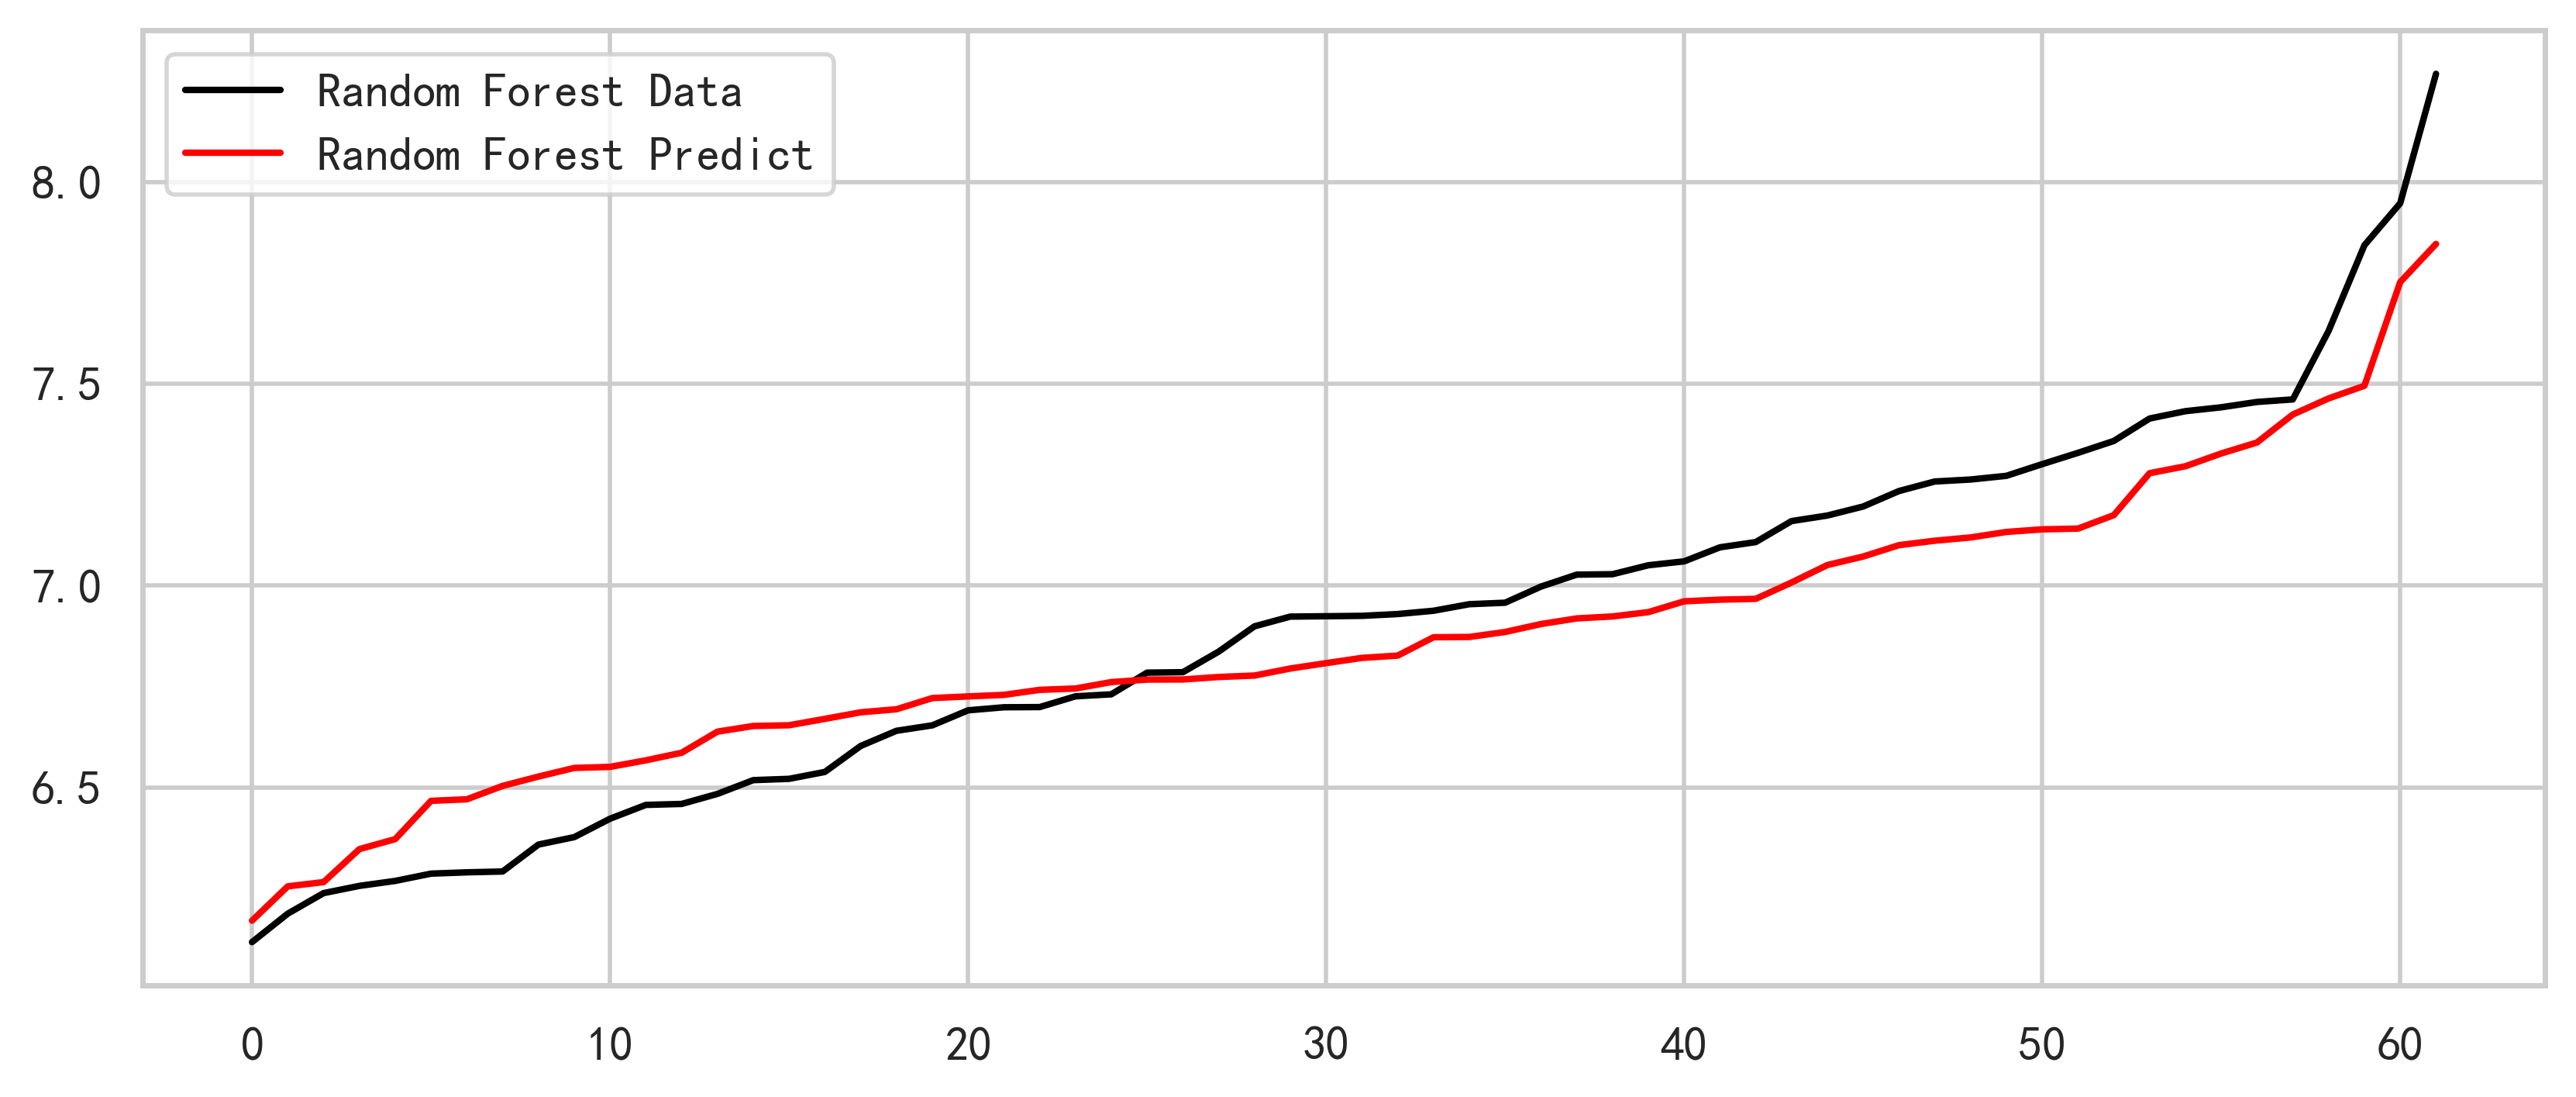

In [145]:
#Evaluate the model performance on material cost
model_evaluate(y_test, y_pred, "Random Forest")